In [53]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

import optuna
import xgboost as xgb

import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [54]:
train_wOrdinal = pd.read_csv('~/Documents/AmesHousingML/clean_data_ordinal.csv') 
train_originalCleaned = pd.read_csv('~/Documents/AmesHousingML/clean_data_original.csv') 
train_wOnlyDummies = pd.read_csv('~/Documents/AmesHousingML/clean_data_dummified.csv') 
train_wOnlyDummiesNoDrop = pd.read_csv('~/Documents/AmesHousingML/clean_data_dummified_noDrop.csv') 

In [55]:
print(train_originalCleaned.shape)
print(train_wOnlyDummies.shape)
print(train_wOrdinal.shape)

train_originalCleaned=train_originalCleaned.drop('PID', axis=1)
train_wOnlyDummies=train_wOnlyDummies.drop('PID', axis=1)
train_wOrdinal=train_wOrdinal.drop('PID', axis=1)

print(train_originalCleaned.shape)
print(train_wOnlyDummies.shape)
print(train_wOrdinal.shape)

(2576, 86)
(2576, 266)
(2576, 86)
(2576, 85)
(2576, 265)
(2576, 85)


## Finding & Dealing with Outliers

In [56]:
outlier_threshold = 3

In [57]:
Q1 = train_wOrdinal['SalePrice'].quantile(.25)
Q3 = train_wOrdinal['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [58]:
before_outlier_total = train_wOrdinal.count()[1]
train_wOrdinal.drop(train_wOrdinal[train_wOrdinal['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_wOrdinal.count()[1]

In [59]:
before_outlier_total - post_outlier_total

23

In [60]:
Q1 = train_originalCleaned['SalePrice'].quantile(.25)
Q3 = train_originalCleaned['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [61]:
before_outlier_total = train_originalCleaned.count()[1]
train_originalCleaned.drop(train_originalCleaned[train_originalCleaned['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_originalCleaned.count()[1]

In [62]:
before_outlier_total - post_outlier_total

23

In [63]:
Q1 = train_wOnlyDummies['SalePrice'].quantile(.25)
Q3 = train_wOnlyDummies['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [64]:
before_outlier_total = train_wOnlyDummies.count()[1]
train_wOnlyDummies.drop(train_wOnlyDummies[train_wOnlyDummies['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_wOnlyDummies.count()[1]

In [65]:
before_outlier_total - post_outlier_total

23

In [66]:
Q1 = train_wOnlyDummiesNoDrop['SalePrice'].quantile(.25)
Q3 = train_wOnlyDummiesNoDrop['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [67]:
before_outlier_total = train_wOnlyDummiesNoDrop.count()[1]
train_wOnlyDummiesNoDrop.drop(train_wOnlyDummiesNoDrop[train_wOnlyDummiesNoDrop['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_wOnlyDummiesNoDrop.count()[1]

In [68]:
before_outlier_total - post_outlier_total

23

In [69]:
masterScores = pd.DataFrame(columns = ['Model', 'r2_5kf_mean', 'rmse_5kf_mean'])

In [70]:
ourFrames = [train_wOrdinal, train_wOnlyDummies, train_wOnlyDummiesNoDrop]

In [71]:
for frame in ourFrames:
    #the features will be X (independent variables)
    X = frame.drop('SalePrice', axis=1)
    X_array = X.values
    #the target (dependent variable) will be y
    y = frame['SalePrice']
    y_array = y.values

    #Split your training and testing sets of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a XGBoost Model
    gb_model = GradientBoostingRegressor(
                                n_estimators=100,  # Number of boosting stages to be run
                                learning_rate=0.1,  # Step size shrinkage to prevent overfitting
                                max_depth=3,  # Maximum depth of the individual trees
                                random_state=42       )

    # Train the model on the training set
    gb_model.fit(X_train, y_train)

    # Make predictions on the test set
    gb_model_y_pred = gb_model.predict(X_test)

    # Evaluate the Random Forest model
    gb_model_r2 = r2_score(y_test, gb_model_y_pred)
    print(f'R-squared on the test set: {gb_model_r2}')

    gb_model_mse = mean_squared_error(y_test, gb_model_y_pred)
    print(f'Mean Squared Error on the test set: {gb_model_mse}')

    # Root Mean Squared Error (RMSE) on the test set
    gb_model_rmse = mean_squared_error(y_test, gb_model_y_pred, squared=False)
    print("Root Mean Squared Error (RMSE) on the test set:", gb_model_rmse)

    # Display feature importances
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': gb_model.feature_importances_})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    print('\nFeature Importances:')
    print(feature_importances)
    
    
    # Create a KFold object
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_scores = cross_val_score(gb_model, X, y, cv=kf, scoring='r2')
    # You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

    # Display the cross-validation scores
    print("Cross-Validation Scores:", cv_scores, '\n')

    # Print the mean and standard deviation of the scores
    print(f"Mean R^2: {cv_scores.mean()}", '\n')
    print(f"Standard Deviation R^2: {cv_scores.std()}")
    
        
    print('\n')
    print('\n')
    print('\n')
    
    # feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
    # feat_importances.nlargest(20).plot(kind='barh')

R-squared on the test set: 0.9334871623396042
Mean Squared Error on the test set: 320521918.04031736
Root Mean Squared Error (RMSE) on the test set: 17903.125929298418

Feature Importances:
               Feature  Importance
17         OverallQual    0.285288
80       HighQualFinSF    0.271180
75        TotalHouseSF    0.172723
19           YearBuilt    0.043406
76  TotalBathroomCount    0.038237
..                 ...         ...
35        BsmtFinType2    0.000000
62          GarageQual    0.000000
45        LowQualFinSF    0.000000
47        BsmtHalfBath    0.000000
42          Electrical    0.000000

[84 rows x 2 columns]
Cross-Validation Scores: [0.93293414 0.90718573 0.9320228  0.9198789  0.86561208] 

Mean R^2: 0.9115267284531348 

Standard Deviation R^2: 0.024799693897104753






R-squared on the test set: 0.9282526802957849
Mean Squared Error on the test set: 345746615.7625672
Root Mean Squared Error (RMSE) on the test set: 18594.262979816307

Feature Importances:
            

In [72]:
train_wOrdinal.head()

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,TotalHouseSF,TotalBathroomCount,QualityOutdoorSF,YearAndRemodAvg,NonHouseSF,HighQualFinSF,HouseLotRatio,FrontageLotRatio,QualityOutdoorLotRatio
0,856,126000,30,5,60.0,7890,1,1,3,3,0,0,0,19,2,2,0,2,6,6,1939,1950,1,0,13,14,2,0.0,3,3,1,4,4,2,3,238.0,1,0.0,618.0,856.0,1,3,1,3,856,0,0,1.0,0.0,1,0,2,1,3,4,6,1,5,5,1939.0,1,2.0,399.0,4,4,2,0,0,0,0,166,1,3,2010,9,4,1712.0,2.0,166,1944.5,-6178.0,1712.0,21.698352,0.760456,2.103929
1,1049,139500,120,5,42.0,4235,1,1,3,3,0,4,0,7,2,2,4,2,5,5,1984,1984,1,0,6,6,1,149.0,4,3,1,5,4,3,3,552.0,2,393.0,104.0,1049.0,1,3,1,3,1049,0,0,1.0,0.0,2,0,2,1,4,5,6,0,1,1,1984.0,3,1.0,266.0,4,4,2,0,105,0,0,0,1,2,2009,9,4,2098.0,3.0,105,1984.0,-2137.0,2098.0,49.539551,0.991736,2.479339
2,1001,124900,30,1,60.0,6060,1,1,3,3,0,4,0,10,2,2,0,2,5,9,1930,2007,3,0,8,8,2,0.0,4,3,0,4,4,2,2,737.0,1,0.0,100.0,837.0,1,5,1,3,1001,0,0,0.0,0.0,1,0,2,1,4,5,6,0,1,5,1930.0,1,1.0,216.0,4,2,0,154,0,42,86,0,1,11,2007,9,4,1838.0,1.0,282,1968.5,-4222.0,1838.0,30.330033,0.990099,4.653465
3,1039,114000,70,5,80.0,8146,1,1,3,3,0,0,0,18,2,2,0,5,4,8,1900,2003,1,0,8,8,2,0.0,4,4,0,3,4,2,1,0.0,1,0.0,405.0,405.0,1,4,1,3,717,322,0,0.0,0.0,1,0,2,1,3,6,6,0,1,5,1940.0,1,1.0,281.0,4,4,0,0,0,168,0,111,1,5,2009,9,4,1444.0,1.0,279,1951.5,-6702.0,1444.0,17.726492,0.982077,3.424994
4,1665,227000,60,5,70.0,8400,1,1,3,3,0,4,0,15,2,2,0,5,8,6,2001,2001,1,0,12,13,2,0.0,4,3,2,5,4,2,3,643.0,1,0.0,167.0,810.0,1,5,1,3,810,855,0,1.0,0.0,2,1,3,1,4,6,6,0,1,1,2001.0,3,2.0,528.0,4,4,2,0,45,0,0,0,1,11,2009,9,4,2475.0,3.5,45,2001.0,-5925.0,2475.0,29.464286,0.833333,0.535714


In [73]:
frame.head()

,PID,GrLivArea,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MoSold,YrSold,MSZoning_A (agr),MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NoAlley,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBsmt,BsmtQual_Po,BsmtQual_TA,BsmtCond_Ex,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_NoBsmt,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBsmt,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBsmt,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBsmt,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFireplace,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Att

In [74]:
#name the model for our scores tracker
model_name = 'scikit_boosting'
    
#the features will be X (independent variables)
X = train_wOrdinal.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = train_wOrdinal['SalePrice']
y_array = y.values

#Split your training and testing sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a XGBoost Model
gb_model = GradientBoostingRegressor(
                            n_estimators=100,  # Number of boosting stages to be run
                            learning_rate=0.1,  # Step size shrinkage to prevent overfitting
                            max_depth=3,  # Maximum depth of the individual trees
                            random_state=42       )

# Train the model on the training set
gb_model.fit(X_train, y_train)

# Make predictions on the test set
gb_model_y_pred = gb_model.predict(X_test)

# Evaluate the Random Forest model
gb_model_r2 = r2_score(y_test, gb_model_y_pred)
print(f'R-squared on the test set: {gb_model_r2}')

gb_model_mse = mean_squared_error(y_test, gb_model_y_pred)
print(f'Mean Squared Error on the test set: {gb_model_mse}')

# Root Mean Squared Error (RMSE) on the test set
gb_model_rmse = mean_squared_error(y_test, gb_model_y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", gb_model_rmse)

# Display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': gb_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print('\nFeature Importances:')
print(feature_importances)
    
    
   # Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(gb_model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

def rmse_scorer(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse
    
    
# Define the scoring function using neg_mean_squared_error
scorer = make_scorer(rmse_scorer)
# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(gb_model, X, y, cv=kf, scoring=scorer)



# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')
print("Cross-Validation Scores RMSE:", rmse_scores, '\n')

# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')
print(f"Mean RMSE: {rmse_scores.mean()}")

record = {'Model': model_name, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
masterScores = masterScores.append(record, ignore_index=True)

R-squared on the test set: 0.9334871623396042
Mean Squared Error on the test set: 320521918.04031736
Root Mean Squared Error (RMSE) on the test set: 17903.125929298418

Feature Importances:
               Feature  Importance
17         OverallQual    0.285288
80       HighQualFinSF    0.271180
75        TotalHouseSF    0.172723
19           YearBuilt    0.043406
76  TotalBathroomCount    0.038237
..                 ...         ...
35        BsmtFinType2    0.000000
62          GarageQual    0.000000
45        LowQualFinSF    0.000000
47        BsmtHalfBath    0.000000
42          Electrical    0.000000

[84 rows x 2 columns]
Cross-Validation Scores Rsquared: [0.93293414 0.90718573 0.9320228  0.9198789  0.86561208] 

Cross-Validation Scores RMSE: [17977.39987634 21053.62004168 17399.33554858 18912.91087184
 23130.10446379] 

Mean R^2: 0.9115267284531348 

Standard Deviation R^2: 0.024799693897104753 

Mean RMSE: 19694.674160446717


In [75]:
masterScores #want to use the sci kit and catboost

,Model,r2_5kf_mean,rmse_5kf_mean
0,scikit_boosting,0.911527,19694.67416


In [76]:
output_file = 'masterScores_scikitBoosting.csv'

masterScores.to_csv(output_file, index=False, mode='w')

print(f"DataFrame exported to '{output_file}' in the same working directory.")

DataFrame exported to 'masterScores_scikitBoosting.csv' in the same working directory.


In [77]:
# def objective(trial):
    
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#     }

#     model = GradientBoostingRegressor(**params, random_state=42)
#     model.fit(X_train, y_train)

#     predictions = model.predict(X_test)
#     mse = mean_squared_error(y_test, predictions)
#     return mse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# best_model = GradientBoostingRegressor(**best_params, random_state=42)
# best_model.fit(X_train, y_train)

In [78]:
best_params

{'n_estimators': 488, 'learning_rate': 0.09127662860772781, 'max_depth': 3}

In [79]:
#{'n_estimators': 488, 'learning_rate': 0.09127662860772781, 'max_depth': 3}
# for actual data, had error about left frame in for df name 
# {'n_estimators': 484, 'learning_rate': 0.061149100472762515, 'max_depth': 3}


In [80]:
best_model

GradientBoostingRegressor(learning_rate=0.09127662860772781, n_estimators=488,
                          random_state=42)

In [81]:
best_params = {'n_estimators': 488, 'learning_rate': 0.09127662860772781, 'max_depth': 3}
best_model = GradientBoostingRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.09127662860772781, n_estimators=488,
                          random_state=42)

In [82]:
best_pred = best_model.predict(X_test)

In [83]:
model_name = 'scikit_boosting_tuned'

# Evaluate the Random Forest model
best_r2 = r2_score(y_test, best_pred)
print(f'R-squared on the test set: {best_r2}')

best_model_mse = mean_squared_error(y_test, best_pred)
print(f'Mean Squared Error on the test set: {best_model_mse}')




# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

    

# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(best_model, X, y, cv=kf, scoring=scorer)



# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')


# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')

record = {'Model': model_name, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
masterScores = masterScores.append(record, ignore_index=True)

R-squared on the test set: 0.9415590761250846
Mean Squared Error on the test set: 281623783.78857714
Cross-Validation Scores Rsquared: [0.94155039 0.9144739  0.94007654 0.92930211 0.87841946] 

Mean R^2: 0.9207644789583522 

Standard Deviation R^2: 0.023283354672743232 



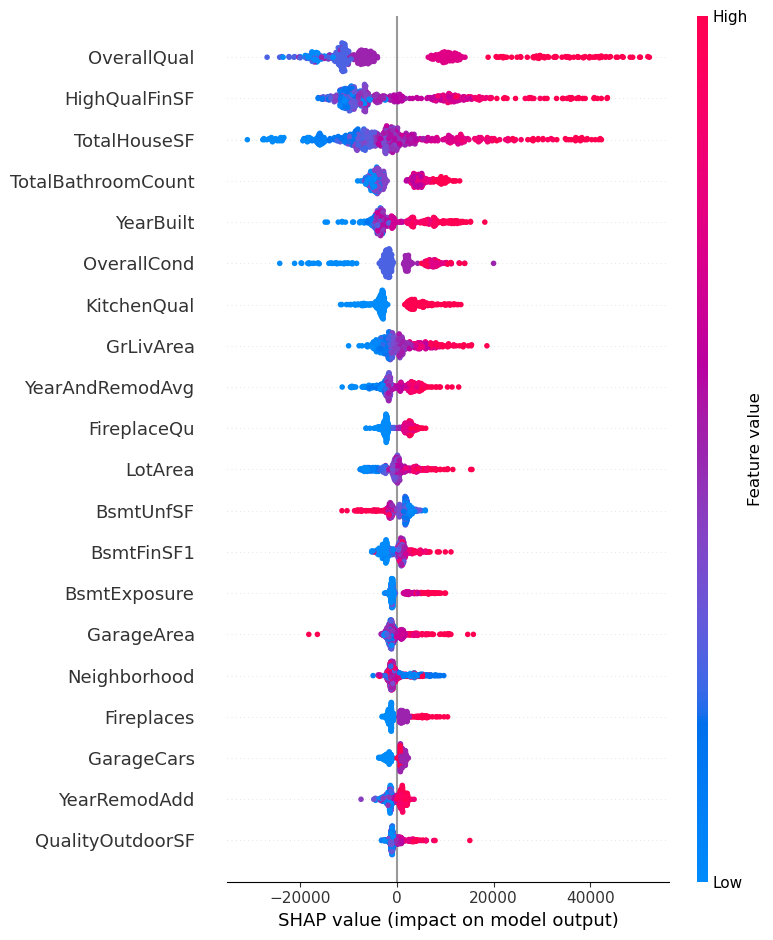

In [86]:
import shap

# Use the SHAP explainer
explainer = shap.Explainer(best_model)

# Calculate SHAP values for a subset of the data (e.g., test set)
shap_values = explainer.shap_values(X_test)

# Plot summary plot
shap.summary_plot(shap_values, X_test)

In [84]:
masterScores

,Model,r2_5kf_mean,rmse_5kf_mean
0,scikit_boosting,0.911527,19694.674160
1,scikit_boosting_tuned,0.920764,18619.087027


In [85]:
output_file = 'masterScores_scikitBoosting.csv'

masterScores.to_csv(output_file, index=False, mode='w')

print(f"DataFrame exported to '{output_file}' in the same working directory.")

DataFrame exported to 'masterScores_scikitBoosting.csv' in the same working directory.
